# Multiclass Prediction of Cirrhosis Outcomes

### Importing dataset from kaggle

In [1]:
import fastkaggle

In [2]:
comp = 'playground-series-s3e26'

In [3]:
fastkaggle.setup_comp(comp)

Path('playground-series-s3e26')

### Importing libraries for the project

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

In [5]:
import warnings
warnings.filterwarnings("ignore")

### About the data
#### Liver cirrhosis: 
> A complication that happens with a body organ, liver. Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption.

> We need to use 17 (clinical) features to predict survival of patient with liver
- 3 classes : 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation)
  - Class 0 (D): The patient didn't survived.
  - Class 1 (C): The patient is censored, meaning that the observation period ended without the event (death) occurring. This means patient still being alive at the time of studyinh this.
  - Class 2 (CL): Similar to Class 1, the patient is censored, but the reason for censorship is specifically due to liver transplantation.

### Uploading the data

In [13]:
df_train = pd.read_csv('data/train.csv')   # Syntetic data
df_original = pd.read_csv('data/cirrhosis.csv')  # original dataset

### Data shape exploration syntetic data

In [7]:
df_train.head()

id  N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0   0     999  D-penicillamine  21532   M       N            N       N     N   
1   1    2574          Placebo  19237   F       N            N       N     N   
2   2    3428          Placebo  13727   F       N            Y       Y     Y   
3   3    2576          Placebo  18460   F       N            N       N     N   
4   4     788          Placebo  16658   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        2.3        316.0     3.35   172.0    1601.0  179.80           63.0   
1        0.9        364.0     3.54    63.0    1440.0  134.85           88.0   
2        3.3        299.0     3.55   131.0    1029.0  119.35           50.0   
3        0.6        256.0     3.50    58.0    1653.0   71.30           96.0   
4        1.1        346.0     3.65    63.0    1181.0  125.55           96.0   

   Platelets  Prothrombin  Stage Status  
0      394.0          9.7    3.0      D  
1      361.0         11.0    3.0      C  
2      199.0         11.7    4.0      D  
3      269.0         10.7    3.0      C  
4      298.0         10.6    4.0      C

In [8]:
df_train.shape

(7905, 20)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

### Cheking for null values and duplication

In [14]:
df_train.isnull().sum().sum()

0

In [23]:
df_train.iloc[:,1:].duplicated().sum()

0

### Data shape exploration original data

In [17]:
df_original.head()

ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N            Y       Y   
2   3    1012      D  D-penicillamine  25594   M       N            N       N   
3   4    1925      D  D-penicillamine  19994   F       N            Y       Y   
4   5    1504     CL          Placebo  13918   F       N            Y       Y   

  Edema  Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0     Y       14.5        261.0     2.60   156.0    1718.0  137.95   
1     N        1.1        302.0     4.14    54.0    7394.8  113.52   
2     S        1.4        176.0     3.48   210.0     516.0   96.10   
3     S        1.8        244.0     2.54    64.0    6121.8   60.63   
4     N        3.4        279.0     3.53   143.0     671.0  113.15   

   Tryglicerides  Platelets  Prothrombin  Stage  
0          172.0      190.0         12.2    4.0  
1           88.0      221.0         10.6    3.0  
2           55.0      151.0         12.0    4.0  
3           92.0      183.0         10.3    4.0  
4           72.0      136.0         10.9    3.0

In [19]:
df_original.shape

(418, 20)

In [20]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [24]:
df_original.iloc[:, 1:].duplicated().sum()

0

In [25]:
df_original.isnull().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

<img src="variable_info.png"/>

> Both datasets are similars. Next step, merge both datasets drop the id columns and make the variable "Status" a category

### Concat both dataset

In [78]:
df = pd.concat([df_train, df_original], axis =0)

In [79]:
# drop the "id" column
df.drop(columns=['id', 'ID'], inplace=True)

In [80]:
df.reset_index(drop=True, inplace=True)

In [81]:
# Dropping ows with null values
df = df.dropna()

### Basic EDA for feature engineering

In [82]:
df.describe(include='all').T

count unique      top  freq          mean          std  \
N_Days         8181.0    NaN      NaN   NaN   2028.452512   1094.82058   
Drug             8181      2  Placebo  4150           NaN          NaN   
Age            8181.0    NaN      NaN   NaN  18366.944994  3685.501456   
Sex              8181      2        F  7578           NaN          NaN   
Ascites          8181      2        N  7782           NaN          NaN   
Hepatomegaly     8181      2        Y  4184           NaN          NaN   
Spiders          8181      2        N  6162           NaN          NaN   
Edema            8181      3        N  7395           NaN          NaN   
Bilirubin      8181.0    NaN      NaN   NaN      2.619423     3.844169   
Cholesterol    8181.0    NaN      NaN   NaN    351.260237    196.85606   
Albumin        8181.0    NaN      NaN   NaN       3.54726     0.348327   
Copper         8181.0    NaN      NaN   NaN     84.471825     76.40377   
Alk_Phos       8181.0    NaN      NaN   NaN   1822.813348  1911.409689   
SGOT           8181.0    NaN      NaN   NaN    114.925595    49.105416   
Tryglicerides  8181.0    NaN      NaN   NaN    115.665322    53.034271   
Platelets      8181.0    NaN      NaN   NaN    265.112333    87.658802   
Prothrombin    8181.0    NaN      NaN   NaN      10.63304     0.790593   
Stage          8181.0    NaN      NaN   NaN      3.032759     0.866041   
Status           8181      3        C  5112           NaN          NaN   

                  min      25%      50%      75%      max  
N_Days           41.0   1230.0   1831.0   2689.0   4795.0  
Drug              NaN      NaN      NaN      NaN      NaN  
Age            9598.0  15574.0  18701.0  20684.0  28650.0  
Sex               NaN      NaN      NaN      NaN      NaN  
Ascites           NaN      NaN      NaN      NaN      NaN  
Hepatomegaly      NaN      NaN      NaN      NaN      NaN  
Spiders           NaN      NaN      NaN      NaN      NaN  
Edema             NaN      NaN      NaN      NaN      NaN  
Bilirubin         0.3      0.7      1.1      3.0     28.0  
Cholesterol     120.0    248.0    299.0    392.0   1775.0  
Albumin          1.96     3.35     3.58     3.77     4.64  
Copper            4.0     39.0     63.0    102.0    588.0  
Alk_Phos        289.0    834.0   1181.0   1857.0  13862.4  
SGOT            26.35    75.95    108.5   137.95   457.25  
Tryglicerides    33.0     84.0    104.0    139.0    598.0  
Platelets        62.0    210.0    265.0    316.0    563.0  
Prothrombin       9.0     10.0     10.6     11.0     18.0  
Stage             1.0      2.0      3.0      4.0      4.0  
Status            NaN      NaN      NaN      NaN      NaN

> Columns 'Days' and 'N_Days' will be converted to year and a new column month and years

> Convert 'Stage' to category 

##### Function to process days columns

In [83]:
def process_day_columns(input_df):
    from datetime import datetime
    # Define the starting date
    df = input_df.copy()
    start_date = datetime(1986, 7, 1)

    # Convert days to months and years using pandas
    df['date'] = start_date + pd.to_timedelta(df['N_Days'], unit='D')
    df['N_Months'] = (df['date'].dt.year - start_date.year) * 12 + df['date'].dt.month - start_date.month
    # Age column to year
    df['Age'] = df['Age'] // 365.25 

    df.drop(columns='date', inplace=True)

    return df


In [87]:
df_proc = process_day_columns(df)

In [88]:
df_proc.head()

N_Days             Drug   Age Sex Ascites Hepatomegaly Spiders Edema  \
0     999  D-penicillamine  58.0   M       N            N       N     N   
1    2574          Placebo  52.0   F       N            N       N     N   
2    3428          Placebo  37.0   F       N            Y       Y     Y   
3    2576          Placebo  50.0   F       N            N       N     N   
4     788          Placebo  45.0   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        2.3        316.0     3.35   172.0    1601.0  179.80           63.0   
1        0.9        364.0     3.54    63.0    1440.0  134.85           88.0   
2        3.3        299.0     3.55   131.0    1029.0  119.35           50.0   
3        0.6        256.0     3.50    58.0    1653.0   71.30           96.0   
4        1.1        346.0     3.65    63.0    1181.0  125.55           96.0   

   Platelets  Prothrombin  Stage Status  N_Months  
0      394.0          9.7    3.0      D        32  
1      361.0         11.0    3.0      C        84  
2      199.0         11.7    4.0      D       112  
3      269.0         10.7    3.0      C        84  
4      298.0         10.6    4.0      C        25

##### Making 'Stage' a category

In [89]:
df_proc.Stage = df_proc.Stage.astype('category')

In [92]:
df_proc.describe().T


count         mean          std     min      25%      50%  \
N_Days         8181.0  2028.452512  1094.820580   41.00  1230.00  1831.00   
Age            8181.0    49.782912    10.089141   26.00    42.00    51.00   
Bilirubin      8181.0     2.619423     3.844169    0.30     0.70     1.10   
Cholesterol    8181.0   351.260237   196.856060  120.00   248.00   299.00   
Albumin        8181.0     3.547260     0.348327    1.96     3.35     3.58   
Copper         8181.0    84.471825    76.403770    4.00    39.00    63.00   
Alk_Phos       8181.0  1822.813348  1911.409689  289.00   834.00  1181.00   
SGOT           8181.0   114.925595    49.105416   26.35    75.95   108.50   
Tryglicerides  8181.0   115.665322    53.034271   33.00    84.00   104.00   
Platelets      8181.0   265.112333    87.658802   62.00   210.00   265.00   
Prothrombin    8181.0    10.633040     0.790593    9.00    10.00    10.60   
N_Months       8181.0    66.147904    35.956767    1.00    40.00    60.00   

                   75%       max  
N_Days         2689.00   4795.00  
Age              56.00     78.00  
Bilirubin         3.00     28.00  
Cholesterol     392.00   1775.00  
Albumin           3.77      4.64  
Copper          102.00    588.00  
Alk_Phos       1857.00  13862.40  
SGOT            137.95    457.25  
Tryglicerides   139.00    598.00  
Platelets       316.00    563.00  
Prothrombin      11.00     18.00  
N_Months         88.00    157.00

### Making new categorical variables using the numerical variables

##### Thrombocytopenia Indicator(Patelets): 
> - Thrombocytopenia Indicator is a binary measure, it flags low platelet counts in blood.
> - Presence (1) indicates thrombocytopenia,  absence (0) denotes normal platelet levels.
> - 130 lower limit
##### Elevated Alkaline Phosphatase Indicator:
> normal range from 44 to 147
##### Normal copper levels
> normal range from 62 to 140
##### Normal Albumin Range
> normal range 3.4 and 5.4
##### Cholestelor and 
> normal less than 200
##### Tryglicerideslimits
> normal less than 150
##### SGOT
> high > 40
##### Bilirubin
> normal_range from 0.2 and 1.2

In [94]:
df_proc.head()

N_Days             Drug   Age Sex Ascites Hepatomegaly Spiders Edema  \
0     999  D-penicillamine  58.0   M       N            N       N     N   
1    2574          Placebo  52.0   F       N            N       N     N   
2    3428          Placebo  37.0   F       N            Y       Y     Y   
3    2576          Placebo  50.0   F       N            N       N     N   
4     788          Placebo  45.0   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        2.3        316.0     3.35   172.0    1601.0  179.80           63.0   
1        0.9        364.0     3.54    63.0    1440.0  134.85           88.0   
2        3.3        299.0     3.55   131.0    1029.0  119.35           50.0   
3        0.6        256.0     3.50    58.0    1653.0   71.30           96.0   
4        1.1        346.0     3.65    63.0    1181.0  125.55           96.0   

   Platelets  Prothrombin Stage Status  N_Months  
0      394.0          9.7   3.0      D        32  
1      361.0         11.0   3.0      C        84  
2      199.0         11.7   4.0      D       112  
3      269.0         10.7   3.0      C        84  
4      298.0         10.6   4.0      C        25

> All Alk_Phos rows are greater than 147. Will not process the column

In [136]:
def feature_eng_num_to_cat(df):
    df_temp = df.copy()
    df_temp['normal_patelets'] = df_temp.Platelets.map(lambda x: "N" if x < 150 else "Y") # Pateletes
    df_temp['normal_cholesterol'] = df_temp.Cholesterol.map(lambda x: "Y" if x < 201 else "N") # Cholesterol
    df_temp['normal_tryglicerides'] = df_temp.Tryglicerides.map(lambda x: "Y" if x < 151 else "N") # Tryglicerides
    df_temp['normal_SGOT'] = df_temp.SGOT.map(lambda x: "Y" if x < 41 else "N") # SGOT
    df_temp['normal_copper'] = df_temp.Copper.map(lambda x: "Y" if x >= 62 and x <= 140 else "N") # Copper
    df_temp['normal_bilirubin'] = df_temp.Bilirubin.map(lambda x: "Y" if x >= 0.2 and x <= 1.2 else "N") # Bilirubin
    df_temp['normal_albumin'] = df_temp.Albumin.map(lambda x: "Y" if x >= 3.4 and x <= 5.4 else "N") # Albumin

    return df_temp

In [137]:
df_new_features = feature_eng_num_to_cat(df_proc)

In [138]:
df_new_features.head()

N_Days             Drug   Age Sex Ascites Hepatomegaly Spiders Edema  \
0     999  D-penicillamine  58.0   M       N            N       N     N   
1    2574          Placebo  52.0   F       N            N       N     N   
2    3428          Placebo  37.0   F       N            Y       Y     Y   
3    2576          Placebo  50.0   F       N            N       N     N   
4     788          Placebo  45.0   F       N            Y       N     N   

   Bilirubin  Cholesterol  ...  Stage  Status  N_Months  normal_patelets  \
0        2.3        316.0  ...    3.0       D        32                Y   
1        0.9        364.0  ...    3.0       C        84                Y   
2        3.3        299.0  ...    4.0       D       112                Y   
3        0.6        256.0  ...    3.0       C        84                Y   
4        1.1        346.0  ...    4.0       C        25                Y   

   normal_cholesterol  normal_tryglicerides  normal_SGOT normal_copper  \
0                   N                     Y            N             N   
1                   N                     Y            N             Y   
2                   N                     Y            N             Y   
3                   N                     Y            N             N   
4                   N                     Y            N             Y   

  normal_bilirubin  normal_albumin  
0                N               N  
1                Y               Y  
2                N               Y  
3                Y               Y  
4                Y               Y  

[5 rows x 27 columns]

## EDA

In [113]:
# Function to get summary stats
def get_summary_stats_by_columns(df):
    column_name = df.columns
    new_df = pd.DataFrame(index=['Data type', 'Min', '25%', '50%', '75%','Max', 'Mean', 'Median', 'Mode', 'Unique Values Num', 'STD', 'Skewness', 'Kurtosis', 'Count'])
    for col in column_name:
        if pd.api.types.is_numeric_dtype(df[col]):
            new_df[col] = [df[col].dtype, df[col].min(), df[col].quantile(.25), df[col].quantile(.5), df[col].quantile(.75),df[col].max(), df[col].mean(), df[col].median(),
                          df[col].mode()[0], df[col].nunique(), df[col].std(), df[col].skew(), df[col].kurt() , df[col].count()]
    return new_df

In [139]:
get_summary_stats_by_columns(df_new_features)

N_Days        Age  Bilirubin Cholesterol   Albumin  \
Data type                int64    float64    float64     float64   float64   
Min                         41       26.0        0.3       120.0      1.96   
25%                     1230.0       42.0        0.7       248.0      3.35   
50%                     1831.0       51.0        1.1       299.0      3.58   
75%                     2689.0       56.0        3.0       392.0      3.77   
Max                       4795       78.0       28.0      1775.0      4.64   
Mean               2028.452512  49.782912   2.619423  351.260237   3.54726   
Median                  1831.0       51.0        1.1       299.0      3.58   
Mode                      1216       52.0        0.6       448.0      3.35   
Unique Values Num          461         50        111         226       160   
STD                 1094.82058  10.089141   3.844169   196.85606  0.348327   
Skewness              0.446759   0.085701   3.320393    3.670952 -0.566693   
Kurtosis             -0.497346  -0.494513  12.733621   18.000006  1.333426   
Count                     8181       8181       8181        8181      8181   

                      Copper     Alk_Phos        SGOT Tryglicerides  \
Data type            float64      float64     float64       float64   
Min                      4.0        289.0       26.35          33.0   
25%                     39.0        834.0       75.95          84.0   
50%                     63.0       1181.0       108.5         104.0   
75%                    102.0       1857.0      137.95         139.0   
Max                    588.0      13862.4      457.25         598.0   
Mean               84.471825  1822.813348  114.925595    115.665322   
Median                  63.0       1181.0       108.5         104.0   
Mode                    67.0        663.0        71.3          90.0   
Unique Values Num        171          364         206           154   
STD                 76.40377  1911.409689   49.105416     53.034271   
Skewness            2.683584     3.190231    1.537139      2.640983   
Kurtosis           10.069168    11.548485     5.77823     14.976514   
Count                   8181         8181        8181          8181   

                    Platelets Prothrombin   N_Months  
Data type             float64     float64      int32  
Min                      62.0         9.0          1  
25%                     210.0        10.0       40.0  
50%                     265.0        10.6       60.0  
75%                     316.0        11.0       88.0  
Max                     563.0        18.0        157  
Mean               265.112333    10.63304  66.147904  
Median                  265.0        10.6       60.0  
Mode                    344.0        10.6         58  
Unique Values Num         227          49        135  
STD                 87.658802    0.790593  35.956767  
Skewness             0.417659     1.34115   0.445364  
Kurtosis             0.320767    4.620801  -0.499125  
Count                    8181        8181       8181

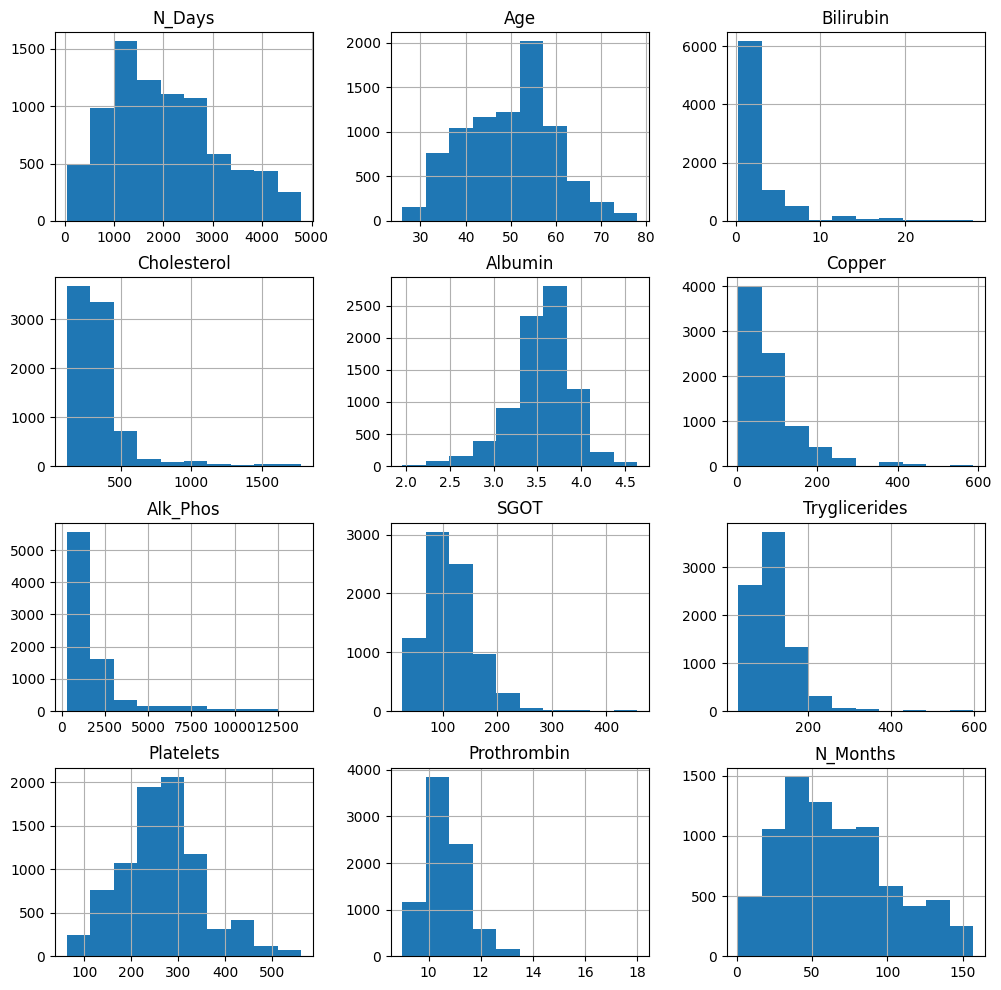

In [116]:
df_new_features.hist(figsize=(12,12));

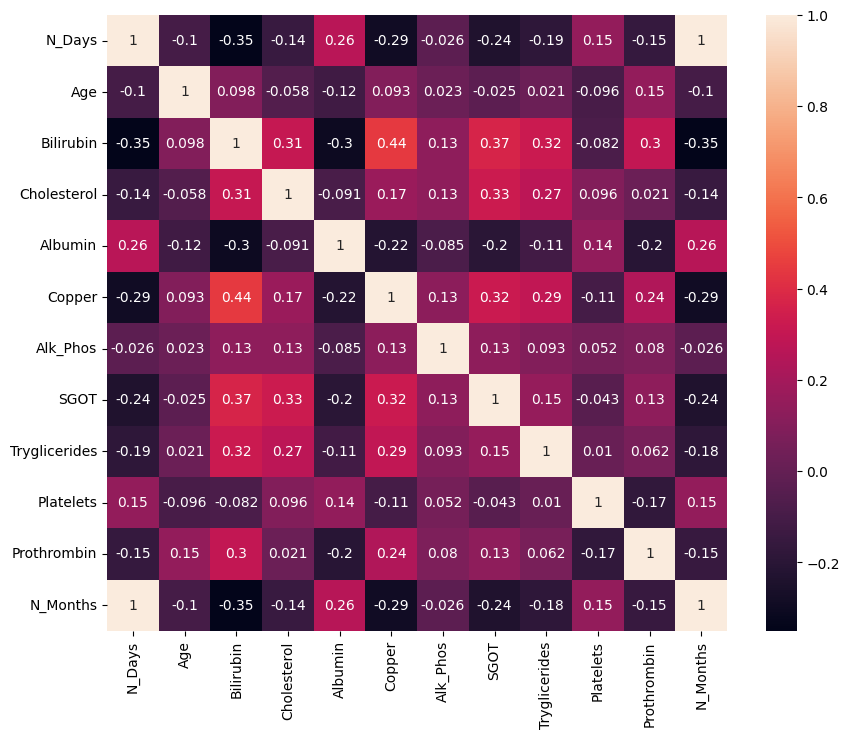

In [118]:
plt.figure(figsize=(10,8))
sns.heatmap(df_new_features.corr(numeric_only=True).round(3), annot=True);

### Categorical Variables

In [140]:
df_new_features.describe(exclude='number').T

count unique      top    freq
Drug                    8181      2  Placebo    4150
Sex                     8181      2        F    7578
Ascites                 8181      2        N    7782
Hepatomegaly            8181      2        Y    4184
Spiders                 8181      2        N    6162
Edema                   8181      3        N    7395
Stage                 8181.0    4.0      3.0  3264.0
Status                  8181      3        C    5112
normal_patelets         8181      2        Y    7449
normal_cholesterol      8181      2        N    7732
normal_tryglicerides    8181      2        Y    6618
normal_SGOT             8181      2        N    8159
normal_copper           8181      2        N    5175
normal_bilirubin        8181      2        Y    4528
normal_albumin          8181      2        Y    5767

In [141]:
cat_cols = df_new_features.describe(exclude='number').columns
len(cat_cols)

15

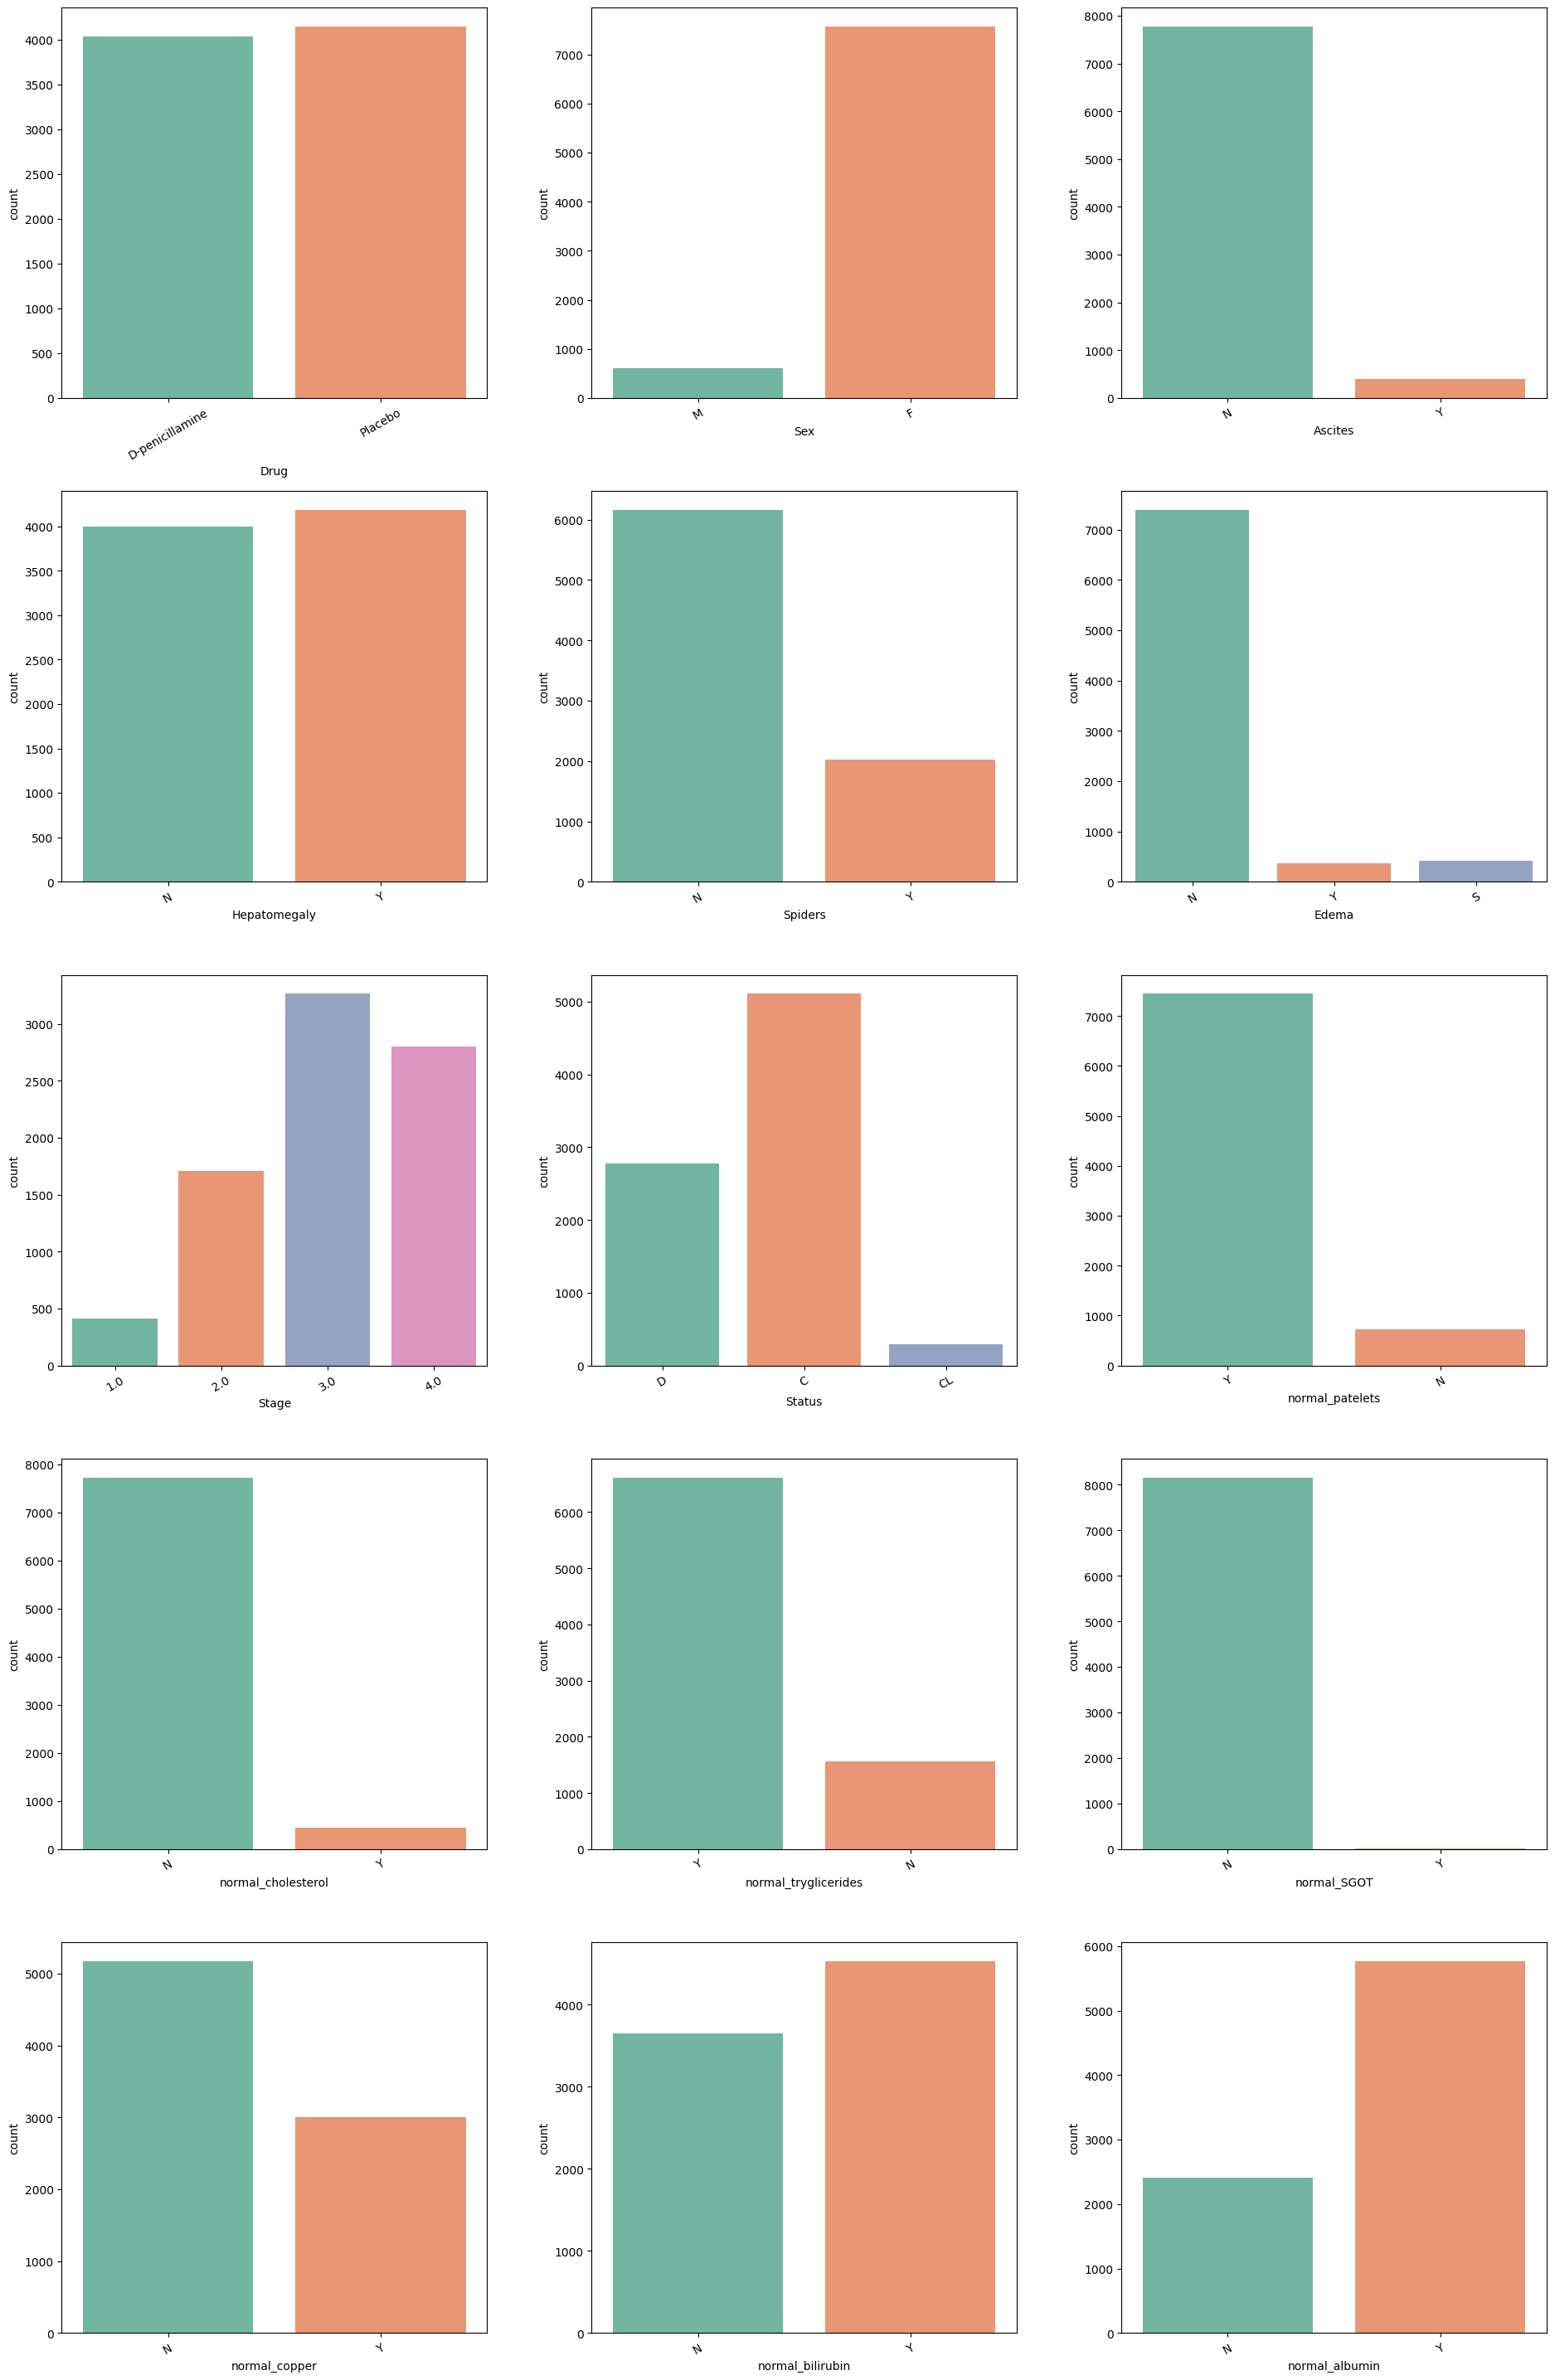

In [143]:
fig, ax = plt.subplots(nrows = 5, ncols = 3, figsize =(20,30))
fig.tight_layout(pad=6.0)
i = 0
for row in range(5):
    for col in range(3):
        g = sns.countplot(x=cat_cols[i], data=df_new_features, ax = ax[row,col], palette = "Set2")
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        i += 1
plt.show()


### Bivariate Charts

#### Status vs numerical

In [144]:
len(df_new_features.describe().columns)

12

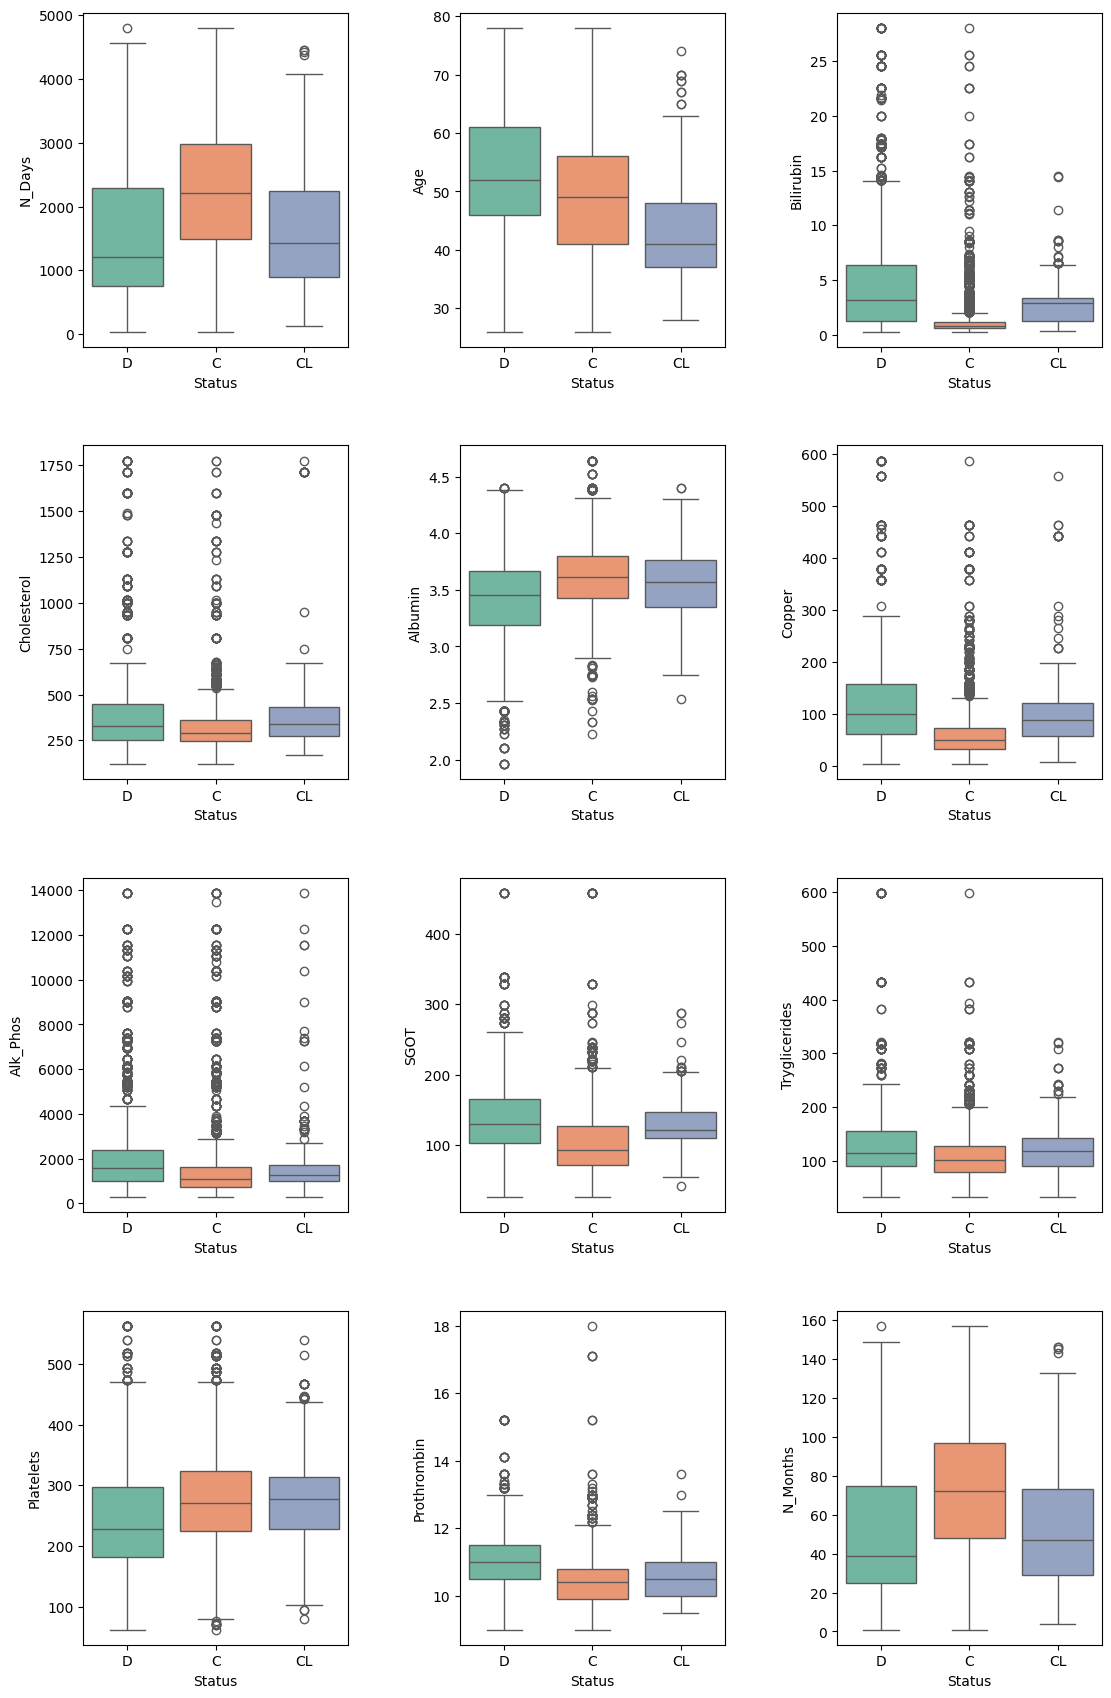

In [147]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize =(12,18))
fig.tight_layout(pad=5.0)
index = 0
for row in range(4):
    for col in range(3):
        sns.boxplot(x='Status', y=df_new_features.describe().columns[index], data=df_new_features, ax = ax[row,col], palette = "Set2");
        index += 1

### Status vs Categorical data

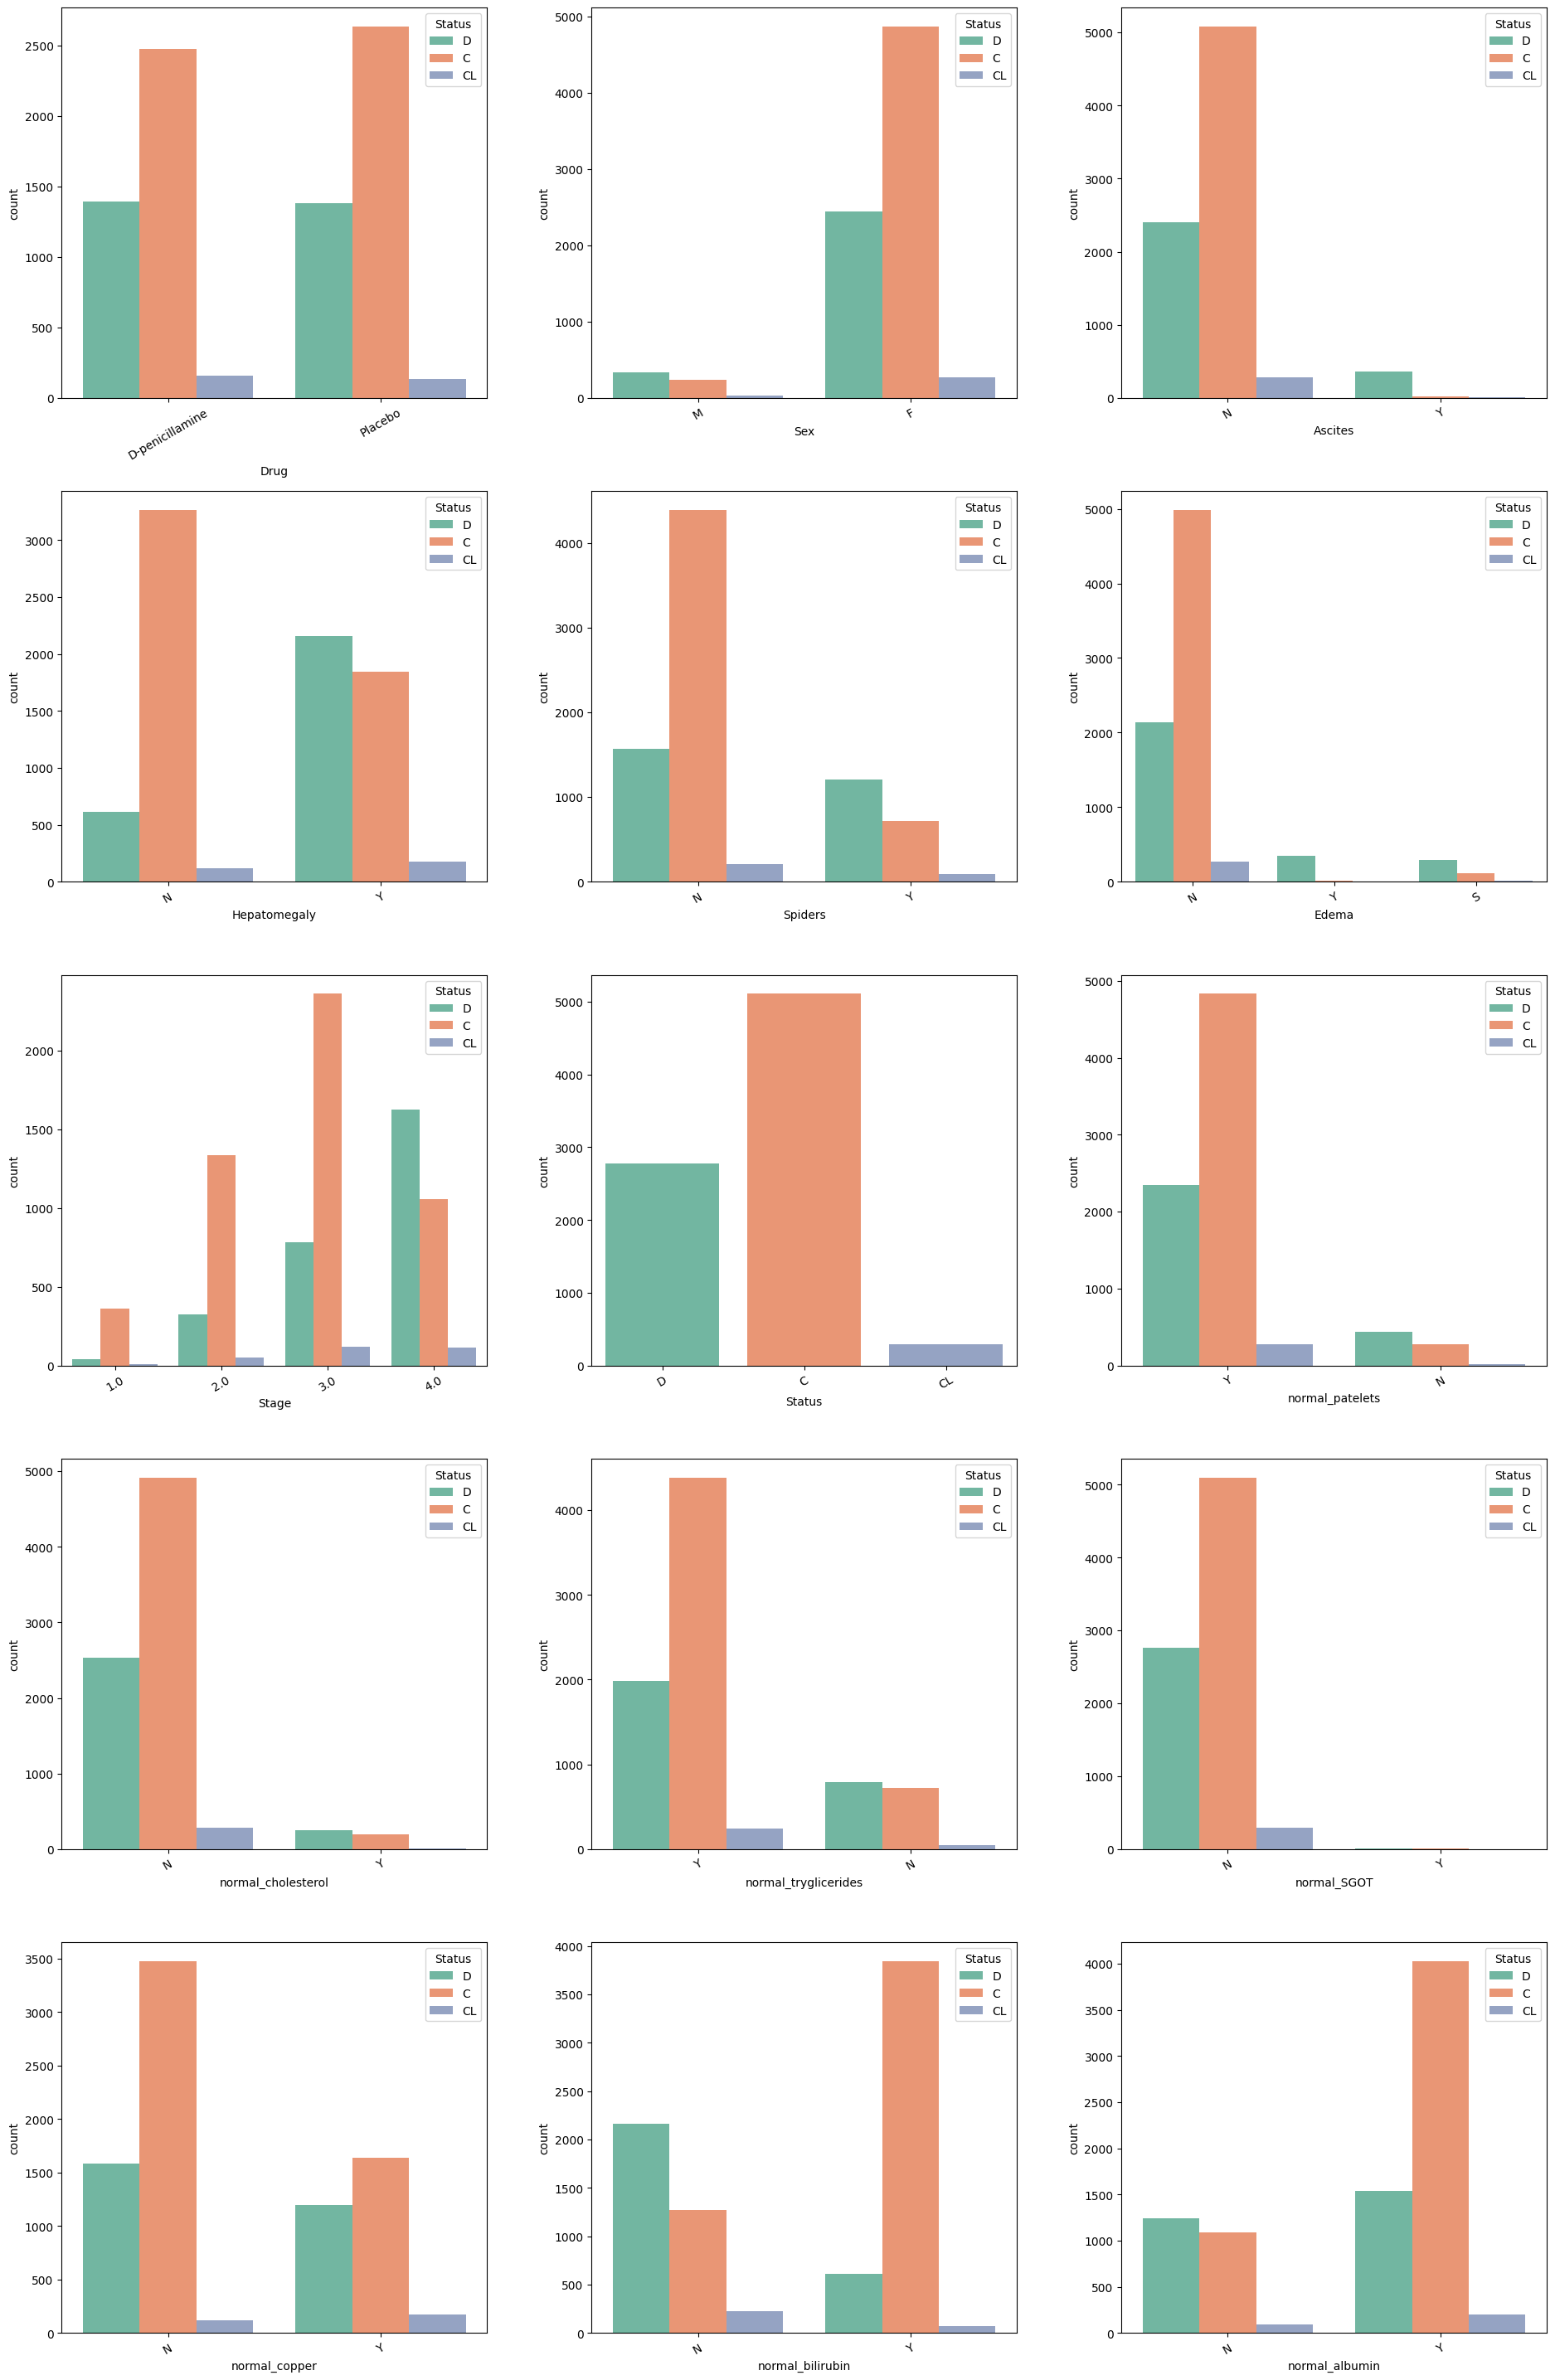

In [149]:
fig, ax = plt.subplots(nrows = 5, ncols = 3, figsize =(20,30))
fig.tight_layout(pad=6.0)
i = 0
for row in range(5):
    for col in range(3):
        g = sns.countplot(x=cat_cols[i], data=df_new_features, ax = ax[row,col], palette = "Set2", hue='Status')
        g.set_xticklabels(g.get_xticklabels(), rotation=30)
        i += 1
plt.show()

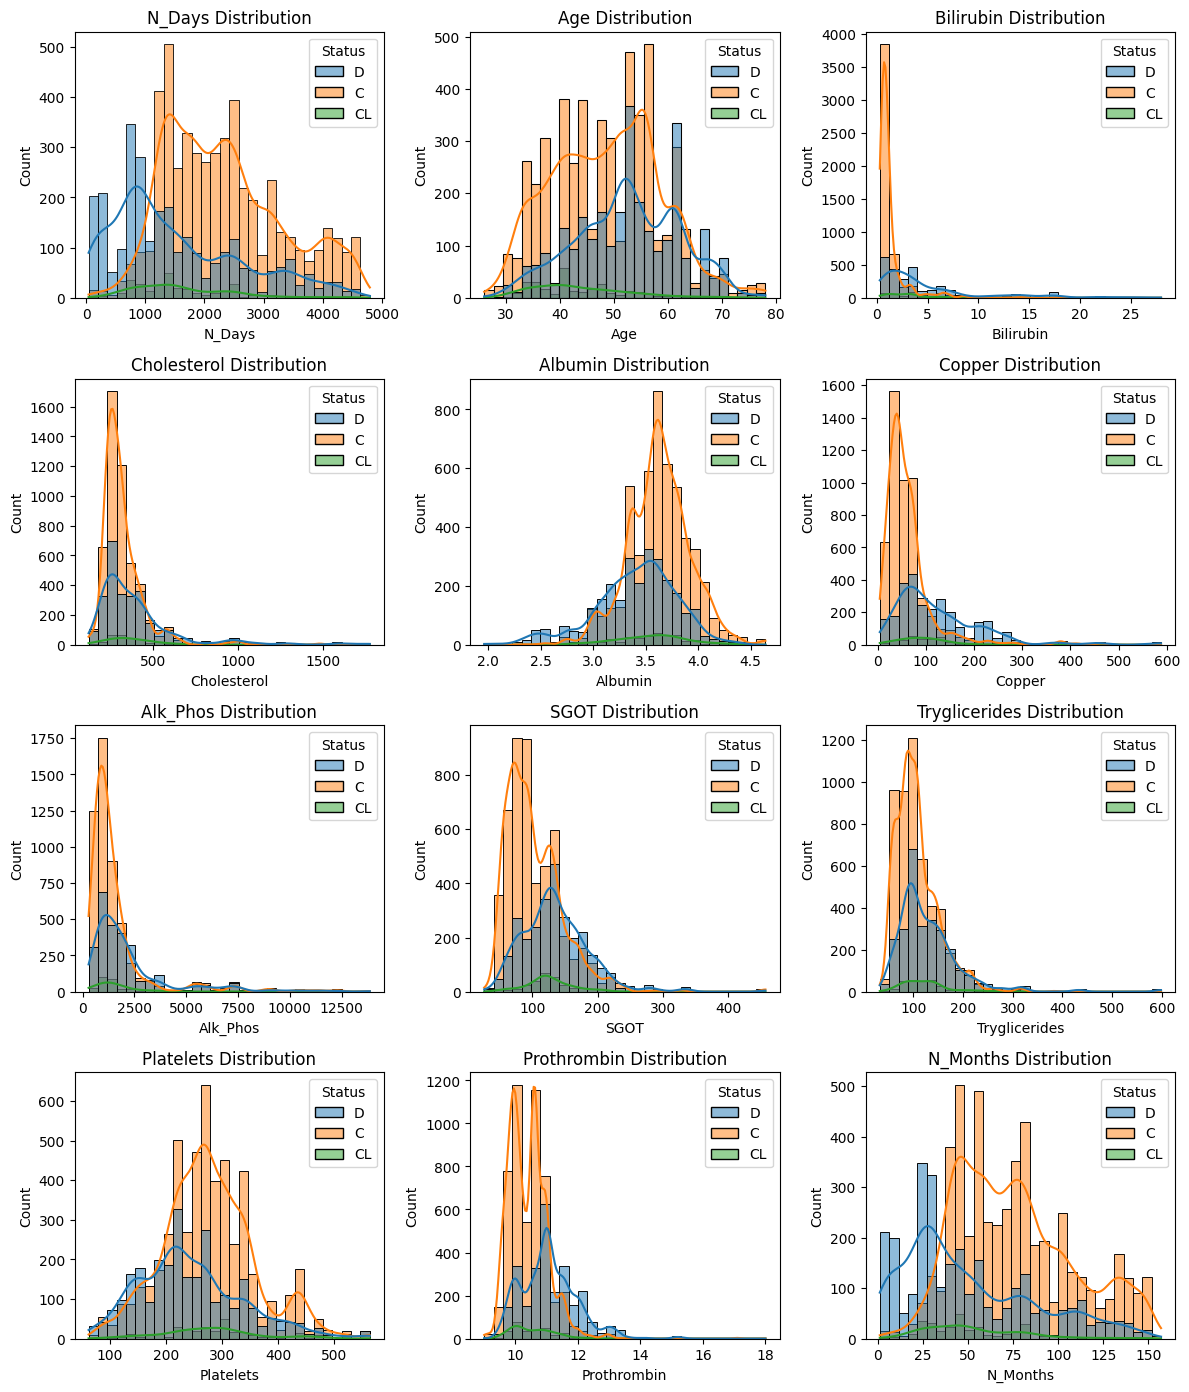

In [150]:
plt.figure(figsize=(12,len(df_new_features.describe().columns)*2))
for idx,column in enumerate(df_new_features.describe().columns):
    plt.subplot(len(df_new_features.describe().columns)//2+1,3,idx+1)
    sns.histplot(x=column, hue='Status', data=df_new_features, bins=30, kde=True)
    plt.title(f"{column} Distribution")
    plt.tight_layout()

## Preparing dataset

### Converting Target variable to numerical

In [151]:
df_new_features.Status = df_new_features.Status.map({"D": 0, "C": 1, "CL": 2})

In [152]:
# Using OrdinalEncoder to encode binary categorical data
from sklearn.preprocessing import OrdinalEncoder

# Making the encoder
encoder = OrdinalEncoder()

In [184]:
df_new_features.describe(exclude='number').columns

Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage',
       'normal_patelets', 'normal_cholesterol', 'normal_tryglicerides',
       'normal_SGOT', 'normal_copper', 'normal_bilirubin', 'normal_albumin'],
      dtype='object')

In [154]:
df_new_features.describe(exclude='number')

Drug   Sex Ascites Hepatomegaly Spiders Edema   Stage  \
count      8181  8181    8181         8181    8181  8181  8181.0   
unique        2     2       2            2       2     3     4.0   
top     Placebo     F       N            Y       N     N     3.0   
freq       4150  7578    7782         4184    6162  7395  3264.0   

       normal_patelets normal_cholesterol normal_tryglicerides normal_SGOT  \
count             8181               8181                 8181        8181   
unique               2                  2                    2           2   
top                  Y                  N                    Y           N   
freq              7449               7732                 6618        8159   

       normal_copper normal_bilirubin normal_albumin  
count           8181             8181           8181  
unique             2                2              2  
top                N                Y              Y  
freq            5175             4528           5767

In [155]:
cols_to_encode = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Stage', 
                  'normal_patelets', 'normal_cholesterol', 'normal_tryglicerides', 
                  'normal_SGOT', 'normal_copper', 'normal_bilirubin', 'normal_albumin']

In [168]:
def encode_cols(df, bi_cols, dummy_nom_list, encoder):
    df_temp = df.copy()
    df_temp[bi_cols] = encoder.fit_transform(df_temp[bi_cols])

    for col in  dummy_nom_list:
        df_temp = pd.concat([df_temp.drop(col, axis = 1),
                            pd.get_dummies(df_temp[col], prefix = col, prefix_sep = '_', drop_first = True, dummy_na = False, dtype='int32')],
                        axis=1)

    return df_temp

In [175]:
df_final = encode_cols(df_new_features, cols_to_encode, ['Edema'],encoder)

In [192]:
df_final.head(3)

N_Days  Drug   Age  Sex  Ascites  Hepatomegaly  Spiders  Bilirubin  \
0     999   0.0  58.0  1.0      0.0           0.0      0.0        2.3   
1    2574   1.0  52.0  0.0      0.0           0.0      0.0        0.9   
2    3428   1.0  37.0  0.0      0.0           1.0      1.0        3.3   

   Cholesterol  Albumin  ...  N_Months  normal_patelets  normal_cholesterol  \
0        316.0     3.35  ...        32              1.0                 0.0   
1        364.0     3.54  ...        84              1.0                 0.0   
2        299.0     3.55  ...       112              1.0                 0.0   

   normal_tryglicerides  normal_SGOT  normal_copper  normal_bilirubin  \
0                   1.0          0.0            0.0               0.0   
1                   1.0          0.0            1.0               1.0   
2                   1.0          0.0            1.0               0.0   

   normal_albumin  Edema_S  Edema_Y  
0             0.0        0        0  
1             1.0        0        0  
2             1.0        0        1  

[3 rows x 28 columns]

### Split the data and Standarize

In [187]:
X = df_final.drop(columns='Status')
y = df_final.Status

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2, stratify=y)

In [193]:
from sklearn.preprocessing import RobustScaler

sc = RobustScaler()

In [195]:
sc_df = sc.fit_transform(X_train)

X_train = pd.DataFrame(sc_df, columns=X_train.columns)

In [199]:
X_train.head(3)

N_Days  Drug       Age  Sex  Ascites  Hepatomegaly  Spiders  Bilirubin  \
0  0.485597   0.0 -0.928571  0.0      0.0          -1.0      0.0  -0.173913   
1  1.046639  -1.0  0.357143  0.0      0.0          -1.0      0.0  -0.260870   
2 -0.066529   0.0  0.571429  0.0      0.0           0.0      0.0   0.478261   

   Cholesterol   Albumin  ...  N_Months  normal_patelets  normal_cholesterol  \
0    -0.593103  0.000000  ...  0.479167              0.0                 0.0   
1    -0.503448 -0.547619  ...  1.041667              0.0                 0.0   
2     0.806897  0.380952  ... -0.062500              0.0                 0.0   

   normal_tryglicerides  normal_SGOT  normal_copper  normal_bilirubin  \
0                   0.0          0.0            0.0               0.0   
1                   0.0          0.0            0.0               0.0   
2                   0.0          0.0            0.0              -1.0   

   normal_albumin  Edema_S  Edema_Y  
0             0.0      0.0      0.0  
1            -1.0      0.0      0.0  
2             0.0      0.0      0.0  

[3 rows x 27 columns]

In [197]:
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [200]:
X_test.head(3)

N_Days  Drug       Age  Sex  Ascites  Hepatomegaly  Spiders  Bilirubin  \
0 -0.266118   0.0 -1.500000  0.0      0.0           0.0      1.0  -0.217391   
1  0.968450   0.0 -0.642857  0.0      0.0          -1.0      0.0  -0.173913   
2 -0.422497   0.0  1.714286  0.0      0.0          -1.0      0.0  -0.260870   

   Cholesterol   Albumin  ...  N_Months  normal_patelets  normal_cholesterol  \
0    -0.544828  0.166667  ... -0.270833              0.0                 0.0   
1    -0.179310  0.380952  ...  0.958333              0.0                 0.0   
2     0.206897  0.452381  ... -0.437500              0.0                 0.0   

   normal_tryglicerides  normal_SGOT  normal_copper  normal_bilirubin  \
0                   0.0          0.0            0.0               0.0   
1                   0.0          0.0            0.0               0.0   
2                   0.0          0.0            0.0               0.0   

   normal_albumin  Edema_S  Edema_Y  
0             0.0      0.0      0.0  
1             0.0      0.0      0.0  
2             0.0      0.0      0.0  

[3 rows x 27 columns]

## Models

### Decision Tree Classifier

In [181]:
from sklearn.tree import DecisionTreeClassifier

In [186]:
# Create the parameter for tunning the Tree Classifier
params = {
    'max_depth': [1, 2, 3, 5, 10, 15, 20, None],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500],
    'criterion': ["gini", "entropy"]
}
dt = DecisionTreeClassifier(random_state=123)
grid_search = GridSearchCV(estimator=dt, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring = "neg_log_loss")

In [201]:
%%time
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
CPU times: user 340 ms, sys: 169 ms, total: 509 ms
Wall time: 3.6 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 5, 10, 15, 20, None],
                         'min_samples_leaf': [1, 5, 10, 20, 50, 100, 200, 500]},
             scoring='neg_log_loss', verbose=1)

In [202]:
preds_dt = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


In [207]:
log_loss(y_test, preds_dt.predict_proba(X_test))

0.5224491533720875

In [210]:
roc_auc_score(y_test, preds_dt.predict_proba(X_test), multi_class='ovr')

0.8228836264957323

### Random Forest for feature importance

In [211]:
rfc = RandomForestClassifier(random_state=123)

In [212]:
# Fiting the model
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [213]:
rfc_pred = rfc.predict_proba(X_test)

In [214]:
log_loss(y_test, rfc_pred)

0.5216245392134683

In [215]:
roc_auc_score(y_test, rfc.predict_proba(X_test), multi_class='ovr')

0.8774563005013188

In [216]:
feature_importance = pd.Series(data=rfc.feature_importances_, index=X_train.columns)

Text(0.5, 1.0, 'Feature of Importance')

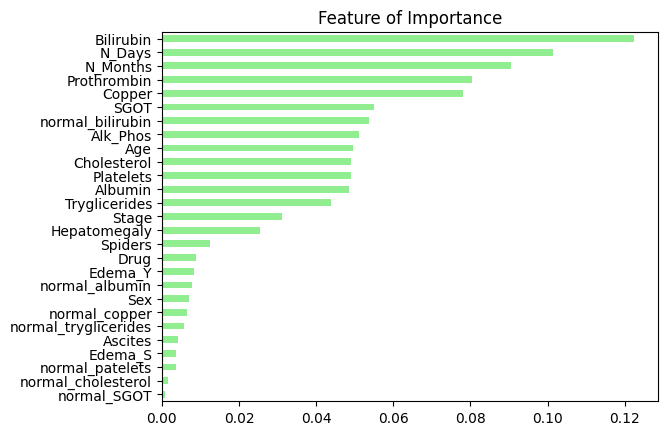

In [217]:
feature_importance.sort_values().plot(kind='barh', color='lightgreen');
plt.title('Feature of Importance')

In [229]:
most_important_features = list(feature_importance.sort_values(ascending=False)[:16].index)
most_important_features

['Bilirubin',
 'N_Days',
 'N_Months',
 'Prothrombin',
 'Copper',
 'SGOT',
 'normal_bilirubin',
 'Alk_Phos',
 'Age',
 'Cholesterol',
 'Platelets',
 'Albumin',
 'Tryglicerides',
 'Stage',
 'Hepatomegaly',
 'Spiders']

## Check Statistically significant of feature 

In [230]:
from sklearn.feature_selection import SelectKBest,  f_classif
skbest = SelectKBest( f_classif, k='all')

In [231]:
# Fit the data
skbest.fit_transform(X, y)

array([[9.990e+02, 0.000e+00, 5.800e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.574e+03, 1.000e+00, 5.200e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.428e+03, 1.000e+00, 3.700e+01, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [9.390e+02, 0.000e+00, 6.200e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [8.390e+02, 0.000e+00, 3.700e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [7.880e+02, 1.000e+00, 3.300e+01, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [232]:
# Making a DataFrame with the result
p_values = pd.DataFrame({'Feature': X.columns,
                         'p_values': skbest.pvalues_}).sort_values('p_values')

In [233]:
p_values[p_values.p_values < 0.05]

Feature       p_values
23      normal_bilirubin   0.000000e+00
7              Bilirubin   0.000000e+00
5           Hepatomegaly  1.508498e-298
15           Prothrombin  6.792506e-294
10                Copper  2.482129e-290
0                 N_Days  9.602545e-232
17              N_Months  1.951922e-231
16                 Stage  4.103652e-227
6                Spiders  3.646201e-194
12                  SGOT  1.545669e-184
9                Albumin  1.755010e-163
26               Edema_Y  8.762961e-153
4                Ascites  1.797577e-143
24        normal_albumin  9.550205e-107
2                    Age   6.504388e-82
13         Tryglicerides   5.936176e-73
8            Cholesterol   2.070524e-66
14             Platelets   7.968510e-56
25               Edema_S   4.586525e-54
20  normal_tryglicerides   1.485268e-52
18       normal_patelets   9.931579e-52
11              Alk_Phos   8.076287e-47
22         normal_copper   9.713321e-36
3                    Sex   9.717915e-33
19    normal_cholesterol   5.912793e-22

#### All columns are statistically significant

In [234]:
len(p_values[p_values.p_values < 0.05])

25

## Trying RandomForest with most important features

In [235]:
X_train_m_imp_fea = X_train.loc[:, most_important_features]

In [236]:
rfc_m_imp_fea = RandomForestClassifier(random_state=123)

In [237]:
rfc_m_imp_fea.fit(X_train_m_imp_fea, y_train)

RandomForestClassifier(random_state=123)

In [238]:
rfc_mif_pred = rfc_m_imp_fea.predict_proba(X_test.loc[:, most_important_features])

In [239]:
log_loss(y_test, rfc_mif_pred)

0.6001025012130982

In [243]:
roc_auc_score(y_test, rfc_m_imp_fea.predict_proba(X_test.loc[:, most_important_features]), multi_class='ovr')

0.8727195208106838

> We got better result with the whole data set. We will keep all the features for future models

### RandomForest with hyper tuning

In [245]:
param_grid = {
	'n_estimators': [25, 50, 100, 150, 200, 500],
	'max_features': ['sqrt', 'log2', None],
	'max_depth': [3, 6, 9, 15, 20],
	'max_leaf_nodes': [3, 6, 9, 15, 50],
}

In [246]:
rfc_new = RandomForestClassifier(random_state=123)

In [262]:
# Running a ne model to find the best params
rfc_cv = GridSearchCV(rfc_new, param_grid=param_grid, cv=5, n_jobs=-1, scoring = 'neg_log_loss')

In [263]:
rfc_cv.fit(X_train, y_train)

/Users/dashelruizperez/.local/share/virtualenvs/capstone_1-GiZkuCZv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9, 15, 20],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9, 15, 50],
                         'n_estimators': [25, 50, 100, 150, 200, 500]},
             scoring='neg_log_loss')

In [264]:
rfc_pred_new = rfc_cv.predict_proba(X_test)

In [266]:
log_loss(y_test, rfc_pred_new)

0.4734200348194517

In [267]:
roc_auc_score(y_test, rfc_pred_new, multi_class='ovr')

0.8683736685557163

### GradientBoostingClassifier

In [268]:
# Define the hyperparameter grid to search
param_grid_gbc = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 1.0],
    'max_depth': [1, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [269]:
gbc = GradientBoostingClassifier(random_state=123)

In [270]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(random_state=123)

In [271]:
gbc_pred = gbc.predict_proba(X_test)

In [272]:
log_loss(y_test, gbc_pred)

0.4322227255790069

In [273]:
roc_auc_score(y_test, gbc_pred, multi_class='ovr')

0.8938511644822152

#### Hyperparameters tuning

In [274]:
# Running a ne model to find the best params
gbc_cv = GridSearchCV(gbc, param_grid=param_grid_gbc, cv=5, n_jobs=-1, scoring = 'neg_log_loss')

In [275]:
gbc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_log_loss')

In [276]:
gbc_pred_cv = gbc_cv.predict_proba(X_test)

In [277]:
log_loss(y_test, gbc_pred_cv)

0.4320600203352197

In [278]:
roc_auc_score(y_test, gbc_pred_cv, multi_class='ovr')

0.8899571768209663

### Optimize XGB with optuna

In [279]:
def objective_xg(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 0.01, 1),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1),
        'eval_metric':trial.suggest_categorical('eval_metric', ['mlogloss']),
    }

    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict_proba(X_test)
    return log_loss(y_test,y_pred)

In [280]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xg, n_trials=100,show_progress_bar=True)

[I 2023-12-10 11:10:18,147] A new study created in memory with name: no-name-998f661b-daeb-443b-be2d-3dd01bdf295f


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-12-10 11:10:18,942] Trial 0 finished with value: 0.4353378360310045 and parameters: {'booster': 'gbtree', 'max_depth': 3, 'learning_rate': 0.06197580082935182, 'n_estimators': 431, 'min_child_weight': 0, 'subsample': 0.3577912972418624, 'colsample_bylevel': 0.4445476946118543, 'colsample_bytree': 0.984213696785887, 'colsample_bynode': 0.20670328181523834, 'reg_alpha': 0.062368693754714745, 'reg_lambda': 0.5402954077073232, 'eval_metric': 'mlogloss'}. Best is trial 0 with value: 0.4353378360310045.
[I 2023-12-10 11:10:19,318] Trial 1 finished with value: 0.5280233998602725 and parameters: {'booster': 'gbtree', 'max_depth': 7, 'learning_rate': 0.01318970954068315, 'n_estimators': 218, 'min_child_weight': 0, 'subsample': 0.5961534623807027, 'colsample_bylevel': 0.719267447774422, 'colsample_bytree': 0.46974316231610336, 'colsample_bynode': 0.12157148921090702, 'reg_alpha': 0.657649112327058, 'reg_lambda': 0.09622283944217833, 'eval_metric': 'mlogloss'}. Best is trial 0 with value:

In [281]:
# Print the best parameters
print('Best parameters', study_xgb.best_params)

Best parameters {'booster': 'gbtree', 'max_depth': 11, 'learning_rate': 0.04216709720284281, 'n_estimators': 504, 'min_child_weight': 1, 'subsample': 0.3437341948452076, 'colsample_bylevel': 0.9831950290382536, 'colsample_bytree': 0.1720049167961935, 'colsample_bynode': 0.7420031757532206, 'reg_alpha': 0.9242740053249385, 'reg_lambda': 0.9419384081768526, 'eval_metric': 'mlogloss'}


In [282]:
xgb = XGBClassifier(**study_xgb.best_params)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict_proba(X_test)

In [283]:
log_loss(y_test, xgb_pred)

0.41429132678911884

In [284]:
roc_auc_score(y_test, xgb_pred, multi_class='ovr')

0.8998046223173285

### Try with LGBMClassifier

In [285]:
def objective_lgb(trial):
    """Define the objective function"""

    params = {
        'objective': trial.suggest_categorical('objective', ['multiclass']),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 25),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 900),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        "random_state" : trial.suggest_categorical('random_state', [42]),
    }

    model_lgb = LGBMClassifier(**params)
    model_lgb.fit(X_train, y_train)
    y_pred = model_lgb.predict_proba(X_test)
    return log_loss(y_test, y_pred)

In [286]:
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50,show_progress_bar=True)

[I 2023-12-10 11:18:11,416] A new study created in memory with name: no-name-39b510f9-f72b-42f0-9404-72964d378501


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 6544, number of used features: 27
[LightGBM] [Info] Start training from score -1.080591
[LightGBM] [Info] Start training from score -0.470248
[LightGBM] [Info] Start training from score -3.330983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [287]:
# Print the best parameters
print('Best parameters', study_lgb.best_params)

Best parameters {'objective': 'multiclass', 'max_depth': 7, 'num_leaves': 67, 'min_child_samples': 20, 'learning_rate': 0.07893056158274839, 'n_estimators': 296, 'subsample': 0.6088401958488068, 'colsample_bytree': 0.05210651481062663, 'reg_alpha': 0.8406057662102785, 'reg_lambda': 0.6297060899710439, 'random_state': 42}


In [288]:
lgb = LGBMClassifier(**study_lgb.best_params)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict_proba(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1870
[LightGBM] [Info] Number of data points in the train set: 6544, number of used features: 26
[LightGBM] [Info] Start training from score -1.080591
[LightGBM] [Info] Start training from score -0.470248
[LightGBM] [Info] Start training from score -3.330983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [290]:
print('Log Loss: ', log_loss(y_test, lgb_pred))

Log Loss:  0.40981352104161367


In [291]:
roc_auc_score(y_test, lgb_pred, multi_class='ovr')

0.9056915122268802